In [20]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from datetime import datetime, timezone

# Convert ISO 8601 date strings to Unix timestamp (milliseconds)
def iso_to_unix(iso_str):
    dt = datetime.strptime(iso_str, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    return int(dt.timestamp() * 1000)  # Convert to milliseconds

def unix_to_iso(unix_timestamp_ms):
    # Convert milliseconds to seconds
    unix_timestamp_s = unix_timestamp_ms / 1000
    # Create a datetime object from the Unix timestamp
    dt = datetime.utcfromtimestamp(unix_timestamp_s)
    # Format the datetime object as an ISO 8601 date string
    iso_str = dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    return iso_str

In [22]:
def start_trading(matrix, prediction, balance, leverage = 2, SL=10, ):
    current_time = matrix[-1][0]
    current_price = matrix[-1][4]

    leverage = leverage
    free_money = balance
    how_much_coin = (leverage*free_money*0.996/current_price)//0.001*0.001    # 0.996 is fee
    
    #
    #if not condition to start trade, dont start trading / trade_status = 0
    #

    #no trade when no money
    if how_much_coin < 0.002:

        trade_status = 0
        direction = 'None'
        TakeProfit = 0
        StopLoss= 0
        entryPrice = 0

        return trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,

    #if wrong prediction, dont start
    if prediction == 0:
        
        trade_status = 0
        direction = 'None'
        TakeProfit = 0
        StopLoss= 0
        entryPrice = 0
        
        return trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,

    #
    #if good conditions to start trade, start strade / trade_status = 1
    #
    
    elif prediction != 0:
        
        #if max - current > current - min == long
        if prediction > 0:
            
            #direction == 1 when long
            direction =  'long'
            ## 1.001 means worse market trade for us
            entryPrice = current_price*1.001
            #TP at 1%       
            TakeProfit = current_price*1.01
            TakeProfit = round(TakeProfit, 1)
            #escape, -1% SL = Stop Loss
            StopLoss = entryPrice*(1-SL/1000)
            StopLoss = np.ceil(StopLoss * 10) / 10

            trade_status = 1
        
            return trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,

        #if max - current < current - min == short
        elif prediction < 0 :

            #direction == -1 when short
            direction = 'short'
            #0.999 means worse market trade for us
            entryPrice = current_price*0.999
            #TP = Take Profit            
            TakeProfit = current_price*0.99
            TakeProfit = round(TakeProfit, 1)
            #escape, -1% SL = Stop Loss
            #0.999 means worse market trade for us
            StopLoss = entryPrice*(1+SL/1000)
            StopLoss = np.floor(StopLoss * 10) / 10

            trade_status = 1
        
            return trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,


In [23]:
#if good chart, our trade ends / return trade_status = 0, new balance, TP=SL=None
#if not, trade keeps going
def end_trading(matrix,balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,):
    current_time = matrix[-1][0]
    open = matrix[-1][1]
    high = matrix[-1][2]
    low = matrix[-1][3]
    close = matrix[-1][4]
    current_price = close

    
    #if long
    if direction == 'long':
        #if SL activate, lose money
        if low <= StopLoss:
            #0.999 means worse market trade for us
            balance = balance + (how_much_coin*StopLoss*0.998 - how_much_coin*entryPrice)    #0.998 is fee
            
            trade_status = 0
            direction = 'None'
            entryPrice = 0
            how_much_coin = 0
            TakeProfit = 0
            StopLoss = 0

            if balance < 0:
                balance = 0
            
            return trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,
        
        
        #if TP activate, earn money
        elif TakeProfit <= high:
            #how_much_coin = (leverage*free_money*0.996/before_price)//0.001*0.001
            balance =   balance + (how_much_coin*TakeProfit*0.998 - how_much_coin*entryPrice)    # 0.998 is fee

            trade_status = 0
            direction = 'None'
            entryPrice = 0
            how_much_coin = 0
            TakeProfit = 0
            StopLoss = 0
            
            return trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,
         
        
        #if nothing happens, do nothing
        elif high < TakeProfit and StopLoss < low:            

            trade_status = 1
            
            return trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,    

        
        
    
    #if short
    elif direction == 'short':
        #if SL activate, lose money
        if StopLoss <= high:
            #1.001 means worse market trade for us
            balance =  balance + (how_much_coin*entryPrice - how_much_coin*StopLoss*0.998)    # 0.998 is fee

            trade_status = 0
            direction = 'None'
            entryPrice = 0
            how_much_coin = 0
            TakeProfit = 0
            StopLoss = 0

            if balance < 0:
                balance = 0
            
            return trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,
        
        
        #if TP activate, earn money
        elif low <= TakeProfit:
            
            balance =  balance + (how_much_coin*entryPrice - how_much_coin*TakeProfit*0.998)    # 0.998 is fee

            trade_status = 0
            direction = 'None'
            entryPrice = 0
            how_much_coin = 0
            TakeProfit = 0
            StopLoss = 0
            
            return trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,
        
        #if nothing happens, do nothing
        elif TakeProfit < low and high < StopLoss:

            trade_status = 1 
                
            return trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,


In [24]:
import time

# Main Backtesting Loop
def BackTest(matrix_array, predictions,leverage=2, SL=10):
    trades = []
    trade_status = 0
    balance = 1000

    # print("Starting backtesting loop with {} entries.".format(len(matrix_array)))
    try:
        for i in range(len(matrix_array)):
            if balance == 0:
                return balance, trades
            # print("Processing index: {}".format(i))
            matrix = matrix_array[i]
            prediction = predictions[i]
            if trade_status == 0:
                trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss, = start_trading(matrix, prediction, balance, leverage,SL, )
                if trade_status != 0:
                    # print(f"Starting trade at index {i}")
                    trades.append([current_time, balance, 'start', direction, entryPrice, TakeProfit, StopLoss,])
            elif trade_status == 1:
                trade_status, current_time, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss, = end_trading(matrix, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss,)
                if trade_status != 1:
                    # print(f"Ending trade at index {i}")
                    trades.append([current_time , balance, 'end', direction, entryPrice, TakeProfit, StopLoss,])
                    
    except Exception as e:
        now = time.localtime(time.time())
        now = time.strftime("%Y-%m-%d %H:%M:%S", now)
        print(f"{now} - Error at index {i}: {e}")
        print(f"Last trade_status: {trade_status}")
        print(f"Last prediction: {prediction}")
        if trade_status == 0:
            print(f"start_trading returned: {start_trading(matrix, prediction, balance)}")
        elif trade_status == 1:
            print(f"end_trading returned: {end_trading(matrix, prediction, balance, direction, entryPrice, how_much_coin, TakeProfit, StopLoss)}")


    # print(f"Number of trades: {len(trades)}")

    return balance, trades

## RFC Model

In [25]:
#predict

predictions = np.load(f'Data/RFC_60_2023_prediction.npy')
matrix_array = np.load('Data/data_2023_matrix_60.npy')
balance, trades = BackTest(matrix_array, predictions)


    

In [29]:

trades_df = pd.DataFrame(trades, columns=['time', 'balance', 'trade_status', 'side', 'entryPrice', 'TakeProfit', 'StopLoss'])


In [30]:
trades_df

,time,balance,trade_status,side,entryPrice,TakeProfit,StopLoss
0,1.672622e+12,1.000000e+03,start,long,16574.12757,16723.1,16408.4
1,1.672644e+12,1.013863e+03,end,None,0.00000,0.0,0.0
2,1.672780e+12,1.013863e+03,start,long,16682.02536,16832.0,16515.3
3,1.672802e+12,1.027937e+03,end,None,0.00000,0.0,0.0
4,1.672837e+12,1.027937e+03,start,long,16827.71090,16979.0,16659.5
...,...,...,...,...,...,...,...
3332,1.703991e+12,1.965183e+12,start,long,42116.36429,42495.0,41695.3
3333,1.704008e+12,1.992505e+12,end,None,0.00000,0.0,0.0
3334,1.704008e+12,1.992505e+12,start,long,42698.31566,43082.2,42271.4
3335,1.704063e+12,1.944914e+12,end,None,0.00000,0.0,0.0


### Plot

/var/folders/mj/m28wyfp54xbfc1pkqh5_b64r0000gn/T/ipykernel_56159/2081820644.py:12: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(unix_timestamp_s)
/var/folders/mj/m28wyfp54xbfc1pkqh5_b64r0000gn/T/ipykernel_56159/2081820644.py:12: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(unix_timestamp_s)


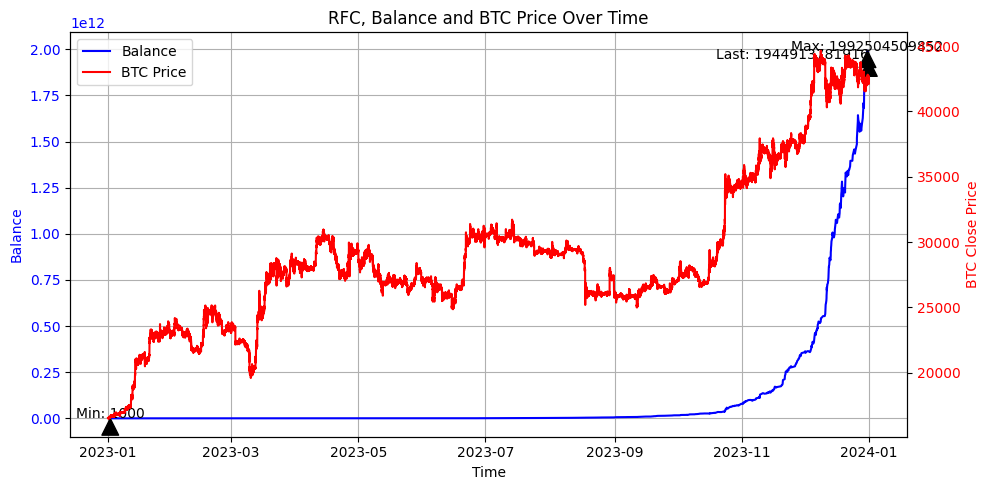

In [31]:
import matplotlib.pyplot as plt

# Load and process trades data
# trades_df = pd.read_csv(f'Data/Backtest/Trades/trades_{filename}.csv')
trades_df['time'] = trades_df['time'].apply(lambda x: unix_to_iso(x))
trades_df['time'] = pd.to_datetime(trades_df['time'])

# Load and process BTC data
btc_df = pd.read_csv('Data/2023_BTCUSDT_3min_data.csv')
btc_df = btc_df[['Open time', 'Close']]
btc_df['time'] = btc_df['Open time'].apply(lambda x: unix_to_iso(x))
btc_df['time'] = pd.to_datetime(btc_df['time'])
btc_df.drop(columns=['Open time'], inplace=True)

# Find the maximum and last balance values
max_balance = trades_df['balance'].max()
min_balance = trades_df['balance'].min()
last_balance = trades_df['balance'].iloc[-1]

time_of_max_balance = trades_df[trades_df['balance'] == max_balance]['time'].iloc[0]
time_of_min_balance = trades_df[trades_df['balance'] == min_balance]['time'].iloc[0]
last_time = trades_df['time'].iloc[-1]

max_balance = round(max_balance)
min_balance = round(min_balance)
last_balance = round(last_balance)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot balance on the primary y-axis
ax1.plot(trades_df['time'], trades_df['balance'], linestyle='-', color='blue', label='Balance')
# ax1.set_ylim(500, 1500)
ax1.set_xlabel('Time')
ax1.set_ylabel('Balance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for BTC close price
ax2 = ax1.twinx()
ax2.plot(btc_df['time'], btc_df['Close'], linestyle='-', color='red', label='BTC Price')
ax2.set_ylabel('BTC Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Annotate the maximum balance
ax1.annotate(f'Max: {max_balance}', 
                xy=(time_of_max_balance, max_balance), 
                xytext=(time_of_max_balance, max_balance + 100),  # Adjust text position
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center')  # Horizontal alignment

# Annotate the minimum balance
ax1.annotate(f'Min: {min_balance}', 
                xy=(time_of_min_balance, min_balance), 
                xytext=(time_of_min_balance, min_balance - 100),  # Adjust text position
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center')  # Horizontal alignment

# Annotate the last balance
ax1.annotate(f'Last: {last_balance}', 
                xy=(last_time, last_balance), 
                xytext=(last_time, last_balance - 100),  # Adjust text position
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='right')  # Horizontal alignment

# Set the title and layout
plt.title(f'RFC, Balance and BTC Price Over Time')
plt.xticks(rotation=45)  # Rotate the x-axis labels for readability
fig.tight_layout()  # Adjust layout

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Save the figure
# fig.savefig(f'Figures/RFC.png')
plt.show()
plt.close(fig)

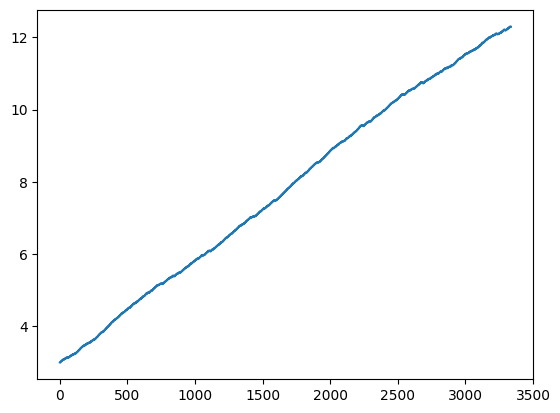

In [35]:
import math
temp = trades_df['balance'].apply(lambda x: math.log10(x))

plt.plot(temp)

/var/folders/mj/m28wyfp54xbfc1pkqh5_b64r0000gn/T/ipykernel_56159/2081820644.py:12: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(unix_timestamp_s)
/var/folders/mj/m28wyfp54xbfc1pkqh5_b64r0000gn/T/ipykernel_56159/2081820644.py:12: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(unix_timestamp_s)


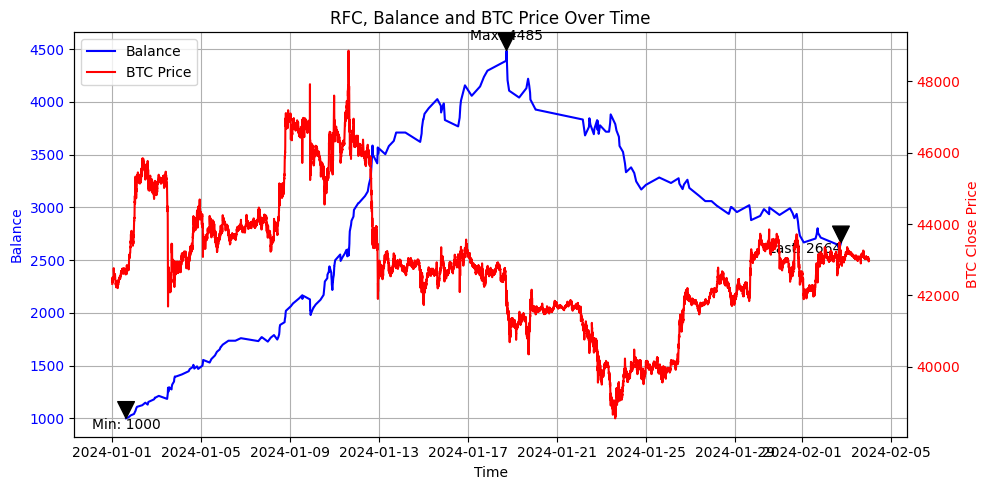

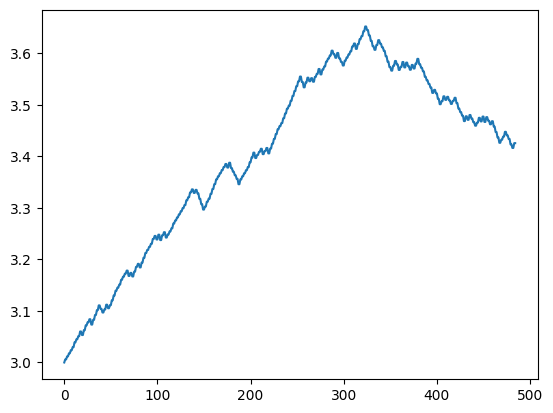

In [36]:
#predict

predictions = np.load(f'Data/RFC_60_2024_prediction.npy')
matrix_array = np.load('Data/data_2024_matrix_60.npy')
balance, trades = BackTest(matrix_array, predictions)

trades_df = pd.DataFrame(trades, columns=['time', 'balance', 'trade_status', 'side', 'entryPrice', 'TakeProfit', 'StopLoss'])

# Load and process trades data
# trades_df = pd.read_csv(f'Data/Backtest/Trades/trades_{filename}.csv')
trades_df['time'] = trades_df['time'].apply(lambda x: unix_to_iso(x))
trades_df['time'] = pd.to_datetime(trades_df['time'])

# Load and process BTC data
btc_df = pd.read_csv('Data/2024_BTCUSDT_3min_data.csv')
btc_df = btc_df[['Open time', 'Close']]
btc_df['time'] = btc_df['Open time'].apply(lambda x: unix_to_iso(x))
btc_df['time'] = pd.to_datetime(btc_df['time'])
btc_df.drop(columns=['Open time'], inplace=True)

# Find the maximum and last balance values
max_balance = trades_df['balance'].max()
min_balance = trades_df['balance'].min()
last_balance = trades_df['balance'].iloc[-1]

time_of_max_balance = trades_df[trades_df['balance'] == max_balance]['time'].iloc[0]
time_of_min_balance = trades_df[trades_df['balance'] == min_balance]['time'].iloc[0]
last_time = trades_df['time'].iloc[-1]

max_balance = round(max_balance)
min_balance = round(min_balance)
last_balance = round(last_balance)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot balance on the primary y-axis
ax1.plot(trades_df['time'], trades_df['balance'], linestyle='-', color='blue', label='Balance')
# ax1.set_ylim(500, 1500)
ax1.set_xlabel('Time')
ax1.set_ylabel('Balance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for BTC close price
ax2 = ax1.twinx()
ax2.plot(btc_df['time'], btc_df['Close'], linestyle='-', color='red', label='BTC Price')
ax2.set_ylabel('BTC Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Annotate the maximum balance
ax1.annotate(f'Max: {max_balance}', 
                xy=(time_of_max_balance, max_balance), 
                xytext=(time_of_max_balance, max_balance + 100),  # Adjust text position
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center')  # Horizontal alignment

# Annotate the minimum balance
ax1.annotate(f'Min: {min_balance}', 
                xy=(time_of_min_balance, min_balance), 
                xytext=(time_of_min_balance, min_balance - 100),  # Adjust text position
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center')  # Horizontal alignment

# Annotate the last balance
ax1.annotate(f'Last: {last_balance}', 
                xy=(last_time, last_balance), 
                xytext=(last_time, last_balance - 100),  # Adjust text position
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='right')  # Horizontal alignment

# Set the title and layout
plt.title(f'RFC, Balance and BTC Price Over Time')
plt.xticks(rotation=45)  # Rotate the x-axis labels for readability
fig.tight_layout()  # Adjust layout

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Save the figure
# fig.savefig(f'Figures/RFC.png')
plt.show()
plt.close(fig)

import math
temp = trades_df['balance'].apply(lambda x: math.log10(x))

plt.plot(temp)